In [1]:
import sys

# Setup the environment if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    ! pip install -r /content/drive/MyDrive/Tübingen/Sem1/DLit/Project/requirements.txt


In [2]:
import os
import re
import json
import requests
import PyPDF2
import urllib.request
from bs4 import BeautifulSoup
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from bayes_opt import BayesianOptimization

sys.path.append('../src/')
import maps
from maps import CONCERNS_MAP, ACTIVITIES_MAP, AGE, SEX

if IN_COLAB:
    os.chdir('/content/drive/MyDrive/Tübingen/Sem1/DLit/Project')

### Read the November 2021 Computer and Internet Use data
To download the data, please run `bash download.sh` in the root directory of this project.

In [3]:
# Set the data directory.
DATA_DIR = '../dat/'
year = '2021'
CSV_FILE_PATH = os.path.join(DATA_DIR, f"{year}/nov{year[2:]}pub.csv")

# Read the data.
df21 = pd.read_csv(CSV_FILE_PATH)
df21 = df21[(df21[AGE] >= 10) * (df21[SEX] != -1)]
columns = df21.columns.to_list()
df21


,HRHHID,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,FILLER,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,...,PXEDTRAI,PXEGOVTS,PXUSESVC,PXESRVCS,PXECOMME,PXEGOODS,PXFINANC,PXVOICEA,PXHOMIOT,PWPRMWGT
0,610905110108708,11,2021,1,201,NaN,1,1,1,-1,...,0,0,0,0,0,0,0,0,0,99445490
1,610905110108708,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
5,721914005500521,11,2021,1,201,NaN,2,1,1,-1,...,0,0,0,0,0,0,0,0,0,38703072
6,201967201670009,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
7,201967201670009,11,2021,1,201,NaN,1,1,1,-1,...,1,1,1,1,1,1,1,1,1,40232619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127369,156485901801505,11,2021,1,201,NaN,1,1,1,-1,...,1,1,1,1,1,1,1,1,1,3958005
127370,156485901801505,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
127372,167066394505701,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
127373,167066394505701,11,2021,1,201,NaN,1,1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0


### Try Classification

In the previous notebook, we performed some initial exploratory analysis on the dataset. We also looked at some of the primary socio-demographic variables that determine whether a person has concerns or hesitations while using the internet. As we also saw in the initial exploration, the dataset is very large, with ~560 columns. 

In order to efficiently explore the other attributes that might affect a person's perception of risks associated with internet use, we now fit an `XGBoost` classifier to predict whether a person would have concerns with internet used, based on other attributes.

We first begin by adding two columns that indicate whether an individual has some hesitation/concern with any aspect of using the internet.

In [5]:
def has_any_concern(row):
    """
    Returns true if the person has answered yes to any of the concerns.
    """
    for column in [f'{item} == 1' for item in [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8]]]:
            if (row['HEPSCON1'] == 1) or (row['HEPSCON2'] == 1) or (row['HEPSCON3'] == 1)\
                    or (row['HEPSCON4'] == 1) or (row['HEPSCON5'] == 1) or (row['HEPSCON6'] == 1)\
                    or (row['HEPSCON8'] == 1):
                return 1
            else:
                return 0

def hesitates_to_do_activity(row):
    """
    Returns true if the person has answered that they hesitate to do any activity.
    """
    for column in [f'{item} == 1' for item in [f'HEPSPRE{i}' for i in [1,2,3,4,5]]]:
            if (row['HEPSPRE1'] == 1) or (row['HEPSPRE2'] == 1) or (row['HEPSPRE3'] == 1)\
                    or (row['HEPSPRE4'] == 1) or (row['HEPSPRE5'] == 1):
                return 1
            else:
                return 0

# Add the new columns to the dataframe.
df21['HAS_SOME_CONCERN'] = df21.apply(has_any_concern, axis=1)
df21['HESITATES'] = df21.apply(hesitates_to_do_activity, axis=1)

### Additional columns

We add a few more derived attributes based on our EDA. Please note that we add only a subset of the defined columns to the data, since some of them are redundant.

In [8]:
# New variables to add based on our custom maps defined in src/maps.py.

# The state a person belongs to - derived from the state code.
state = lambda x: pd.Categorical(x['GESTFIPS'].map(maps.StatesMap))
# The region a person belongs to - derived from the state code.
region = lambda x: pd.Categorical(x['STATE'].map(maps.RegionsMap))
# Level of education - detailed
educdt = lambda x: pd.Categorical(x['PEEDUCA'].map(maps.EducDTMap))
# Level of education - broad
educ = lambda x: pd.Categorical(x['PEEDUCA'].map(maps.educ))
# Currently enrolled in school
schenr = lambda x: pd.Categorical(
    np.where(x['PESCHENR'] == 1, 1,
    np.where(x['PESCHENR'] == 2, 0, None)))
# marital status
married = lambda x: pd.Categorical(
    np.where(x['PRMARSTA'].isin([1, 2, 3]), 1, 0))

# Race - detailed
wbao = lambda x: pd.Categorical(x['PRDTRACE'].map(maps.race))

# Veteran status
veteran = lambda x: pd.Categorical(
    np.where(x['PEAFEVER'] == 1, 1,
    np.where(x['PEAFEVER'] == 2, 0, None)))

# Citizenship status
forborn = lambda x: pd.Categorical(
    np.where(x['PRCITSHP'].isin([4, 5]), 1,
    np.where(x['PRCITSHP'].isin([1, 2, 3]), 0, None)))

# Citizenship status
citizen = lambda x: pd.Categorical(
    np.where(x['PRCITSHP'].isin([1, 2, 3, 4]), 1,
    np.where(x['PRCITSHP'].isin([5]), 0, None)))

# Industry of employment - detailed
indgrp =  lambda x: pd.Categorical(x['PRMJIND1'].map(maps.ind))

# Management occupation
manager = lambda x: np.where(x.PRDTOCC1 == 1, 1,
                    np.where(x.PRDTOCC1 > 0, 0, None))

# Multiple job holder status
mjh = lambda x: pd.Categorical(
    np.where(x['PRSJMJ']==2, 1, np.where(x['PRSJMJ']==1, 0, None)))

# Number of jobs
numjobs = lambda x: np.where(x.PEMJNUM > 1, x.PEMJNUM,
    np.where((x.MJH == 0) & (x.LFS == "Employed"), 1, 0))

# Type of employment
unemptype = lambda x: pd.Categorical(
    np.where(x['PRUNTYPE'].isin([1, 2, 3]), 'Job Loser',
    np.where(x['PRUNTYPE'] == 4, 'Job Leaver',
    np.where(x['PRUNTYPE'] == 5, 'Re-entrant',
    np.where(x['PRUNTYPE'] == 6, 'New Entrant', None)))))

# Reason for unemployment
layoff = lambda x: pd.Categorical(
    np.where(x['PEMLR'] == 3, 'Layoff',
    np.where(x['PEMLR'] == 4, 'Looking', None)))

# Layoff duration
lfs = lambda x: pd.Categorical(
        np.where(x['PEMLR'].isin([1, 2]), 'Employed',
        np.where(x['PEMLR'].isin([3, 4]), 'Unemployed',
        np.where(x['PEMLR'].isin([5, 6, 7]), 'NILF', np.nan))))

# Education
school = lambda x: pd.Categorical(
        np.where(x.PESCHLVL == 1, 'High School',
        np.where((x.PESCHLVL == 2) & (x.PESCHFT == 1), 'Full-time College',
        np.where((x.PESCHLVL == 2) & (x.PESCHFT == 2), 'Part-time College',
        np.where(x.SCHENR == 0, 'Not Enrolled', None)))))

# Work status - full time?
uslft = lambda x: pd.Categorical(
        np.where((x['PEHRFTPT'] == 1) | (x['PEHRUSL1'] >= 35), 1,
        np.where(x['PEHRFTPT'] == 2, 0,
        np.where(x['PEHRFTPT'] == 3, -4, None))))


df21 = (df21.assign(STATE = state(df21),
    EDUCDT = educdt(df21),
    SCHENR = schenr(df21),
    MARRIED = married(df21),
    VETERAN = veteran(df21),
    FORBORN = forborn(df21),
    CITIZEN = citizen(df21),
    UNEMPTYPE = unemptype(df21),
    LAYOFF = layoff(df21),
    USLFT = uslft(df21),
    )
)

df21 = df21.assign(REGION = region(df21), SCHOOL = school(df21))

### Prepare the data for training

We create a copy of the dataframe, and remove some of the obvious / highly correlated attributes.

In [12]:
# loop through all columns in df21, and add all non numerical and non categorical columns to a list
non_numerical_cols = []
for col in df21.columns:
    if df21[col].dtype == object:
        non_numerical_cols.append(col)

# add columns that contain all NaN values to the list
for col in df21.columns:
    if df21[col].isnull().all():
        non_numerical_cols.append(col)

# Some other columns that are highly correlated with the target variable, and hence should be dropped to help
# us discover other features that more interestingly correlate with the target variable.
non_numerical_cols += ["HAS_SOME_CONCERN", "HESITATES"] + ["HEPSCON" + str(i) for i in range(1, 9)] + ["HEPSPRE" + str(i) for i in range(1, 6)]

# drop all non numerical and non categorical columns from df21
df_train = df21.drop(columns = non_numerical_cols, errors="ignore")

In [15]:
# reference: https://www.kaggle.com/code/tilii7/bayesian-optimization-of-xgboost-parameters
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    """
    Hyperparm seach for binary classification
    """
    params = {'eval_metric': 'error',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'tree_method': 'gpu_hist',
              'predictor': 'gpu_predictor',
              'verbosity': 0}
    # Use around 1000 boosting rounds in the full model
    # Perform 3-fold Cross-validation (CV), and calculate the CV error for each fold.
    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=3)

    return -cv_result['test-error-mean'].iloc[-1]

In [22]:
os.mkdir(f'../res/{year}')

# Use the below as the target variables in order to find the most important features for each of them.
columns_to_process = [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8]] + [f'HEPSPRE{i}' for i in [1,2,3,4,5]] + ["HAS_SOME_CONCERN", "HESITATES"]

for column in columns_to_process:

  # Filter out all rows where the target variable is -1
  df21_filtered = df21[df21[column] != -1][column]

  # The other columns use 2 for yes and 1 for no, so we need to convert them to 1 and 0 respectively.
  if column not in ["HAS_SOME_CONCERN", "HESITATES"]:
    df21_filtered = df21_filtered.apply(lambda x : x-1)

  # Create new variable for filtered df_train1
  df_train1_filtered = df_train.loc[df21_filtered.index]

  # Create DMatrix for XGBoost classifier
  xgtrain = xgb.DMatrix(df_train1_filtered, label=df21_filtered, enable_categorical=True)

  # Perform hyperparameter search
  xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (7, 12),
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.5, 0.9)})
  xgb_bo.maximize(init_points=5, n_iter=10)

  # Get the best parameters
  sorted_res = sorted(xgb_bo.res,key = lambda x: x['target'])
  params = sorted_res[-1]
  params['params']['max_depth'] = int(params['params']['max_depth'])

  # Train the model with the best parameters on the entire dataset
  model = xgb.train(params, xgtrain, num_boost_round=1000)

  # Reference: https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
  # Save the feature importance to a file
  feature_important = model.get_score(importance_type='gain')
  keys = list(feature_important.keys())
  values = list(feature_important.values())

  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
  fig = data.nlargest(30, columns="score").plot(kind='barh', figsize = (20,10)).get_figure() 

  fig.savefig(f'../res/{year}/{column}.jpg')
  data.to_csv(f'../res/{year}/{column}.csv')


FileExistsError: [Errno 17] File exists: '../res/2021'

### Feature Importance

As we can see, the model is able to fit the data well - we get a 3-fold cross validation error of around 8-14%, so the classifier is able to predict the target variables well. We now plot the top 20 features for each of the target variables. We categorize the columns into categories such as work, financial, digital access, safety, etc.

In [5]:
from maps import feat_dict


### Final Importance plots

Below, we plot the categorized variables that are important to determin each target variable.

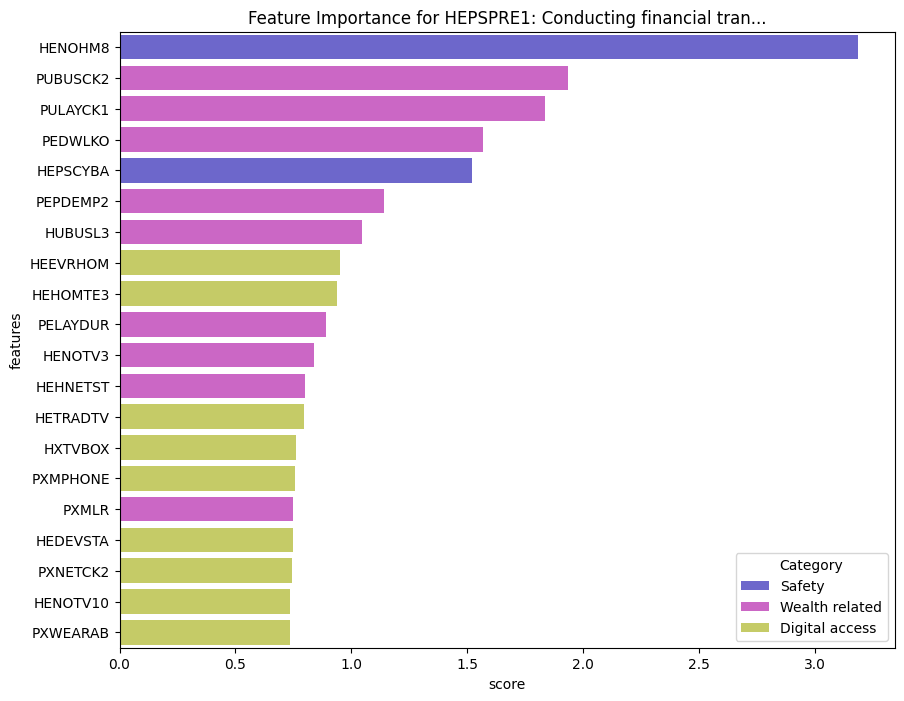

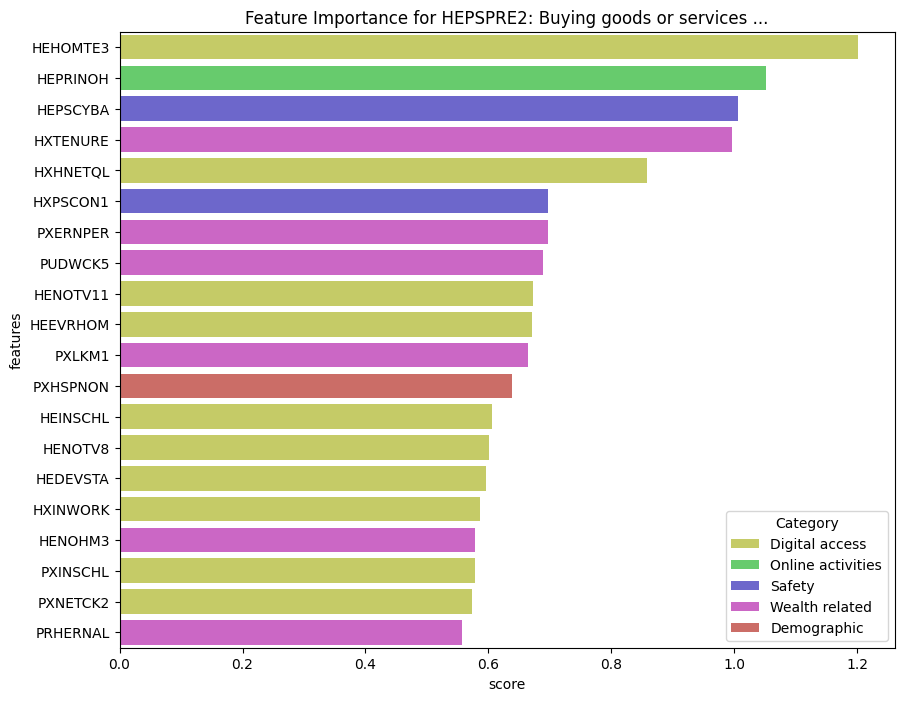

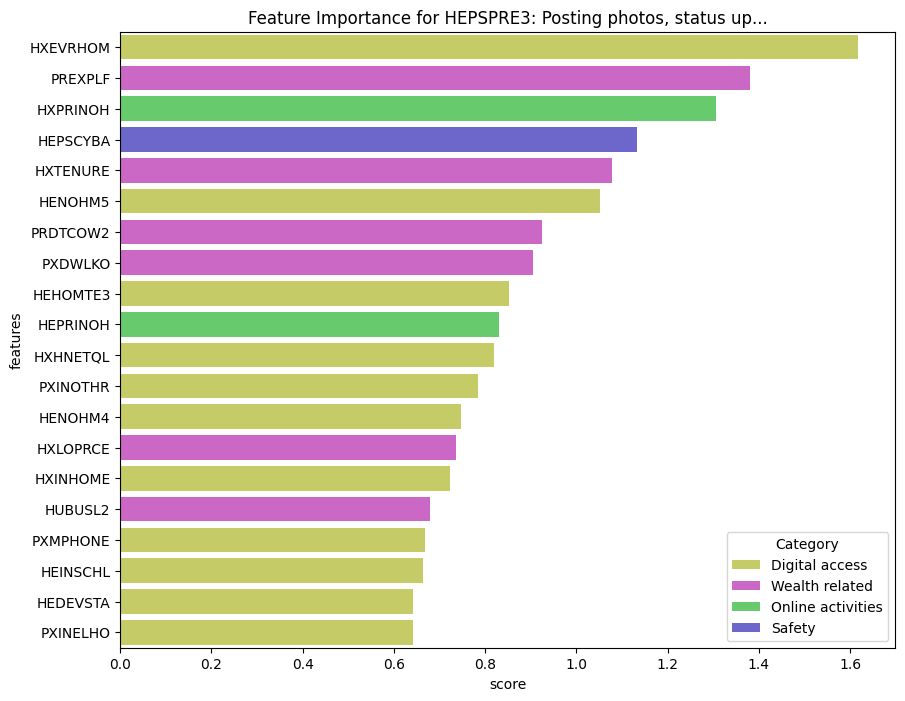

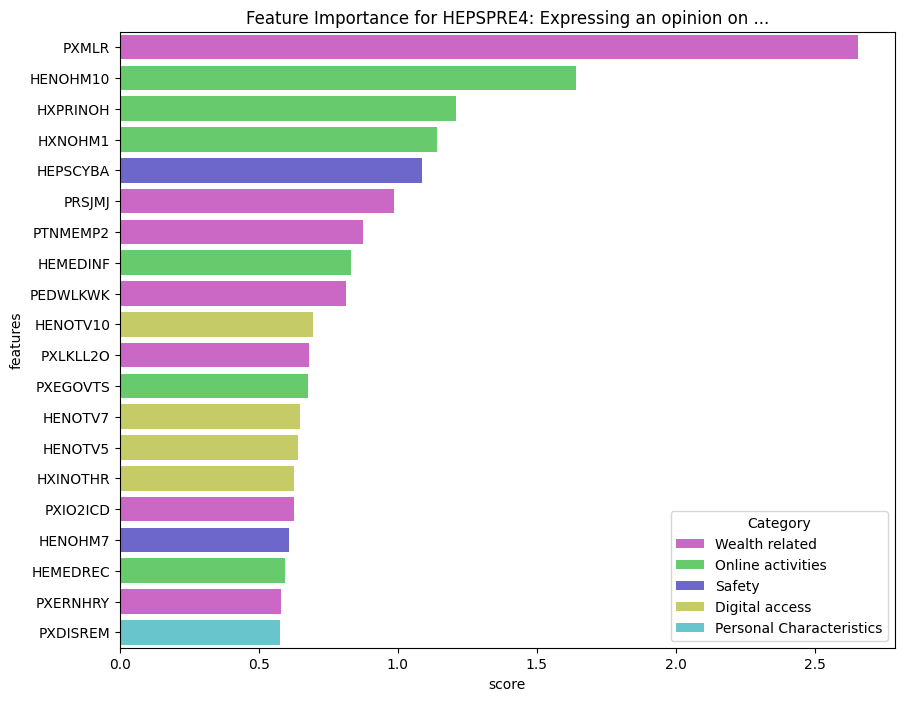

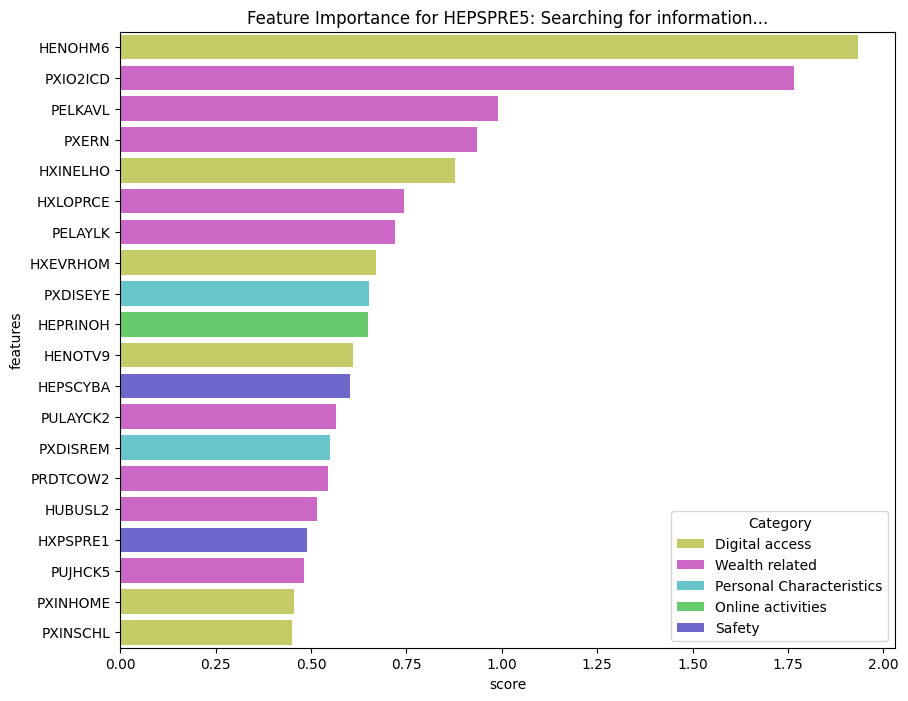

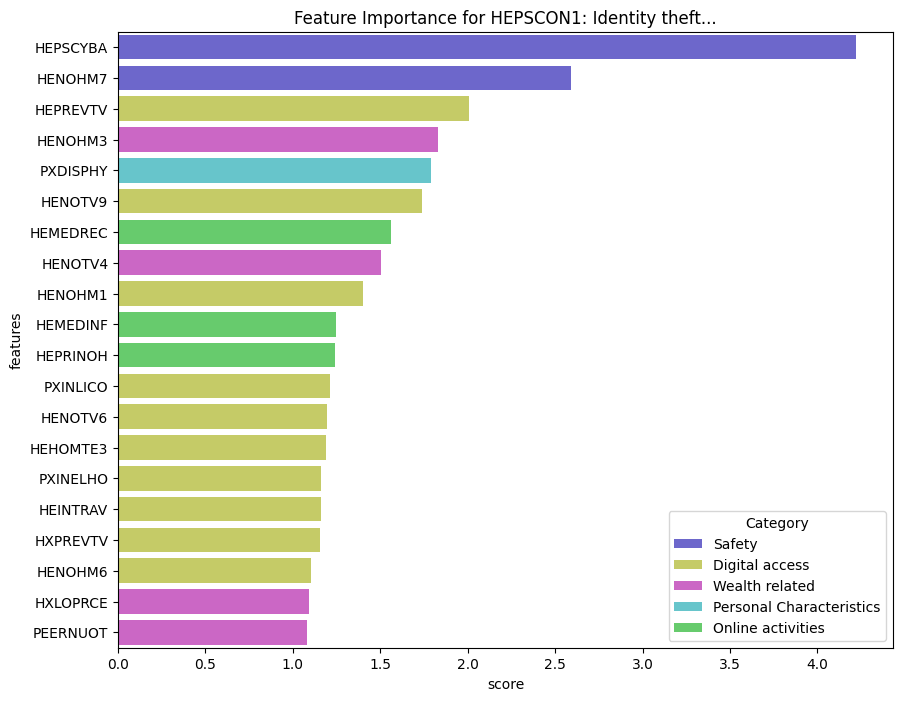

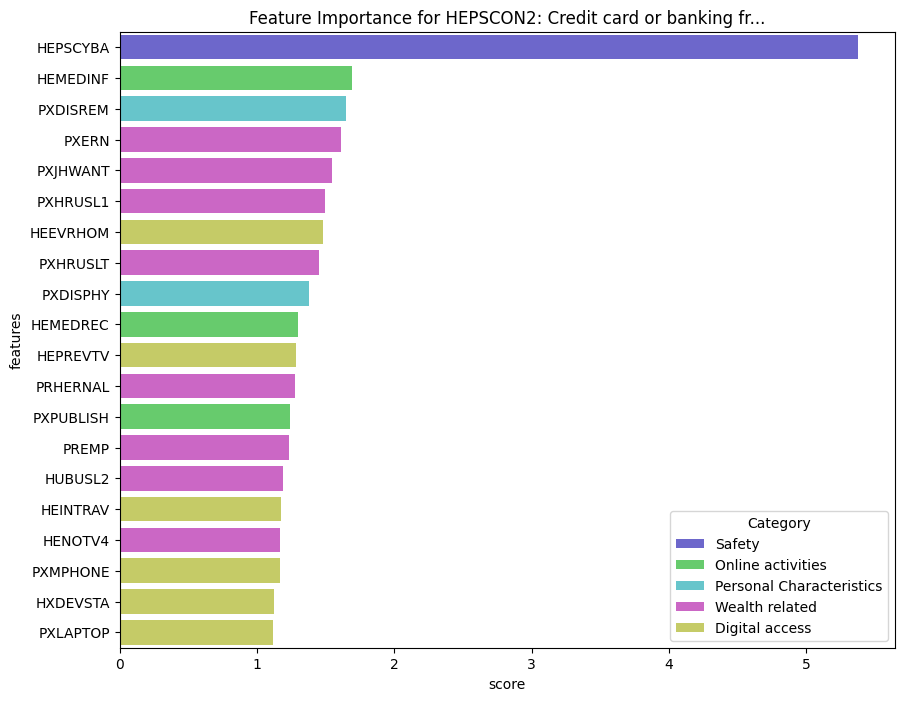

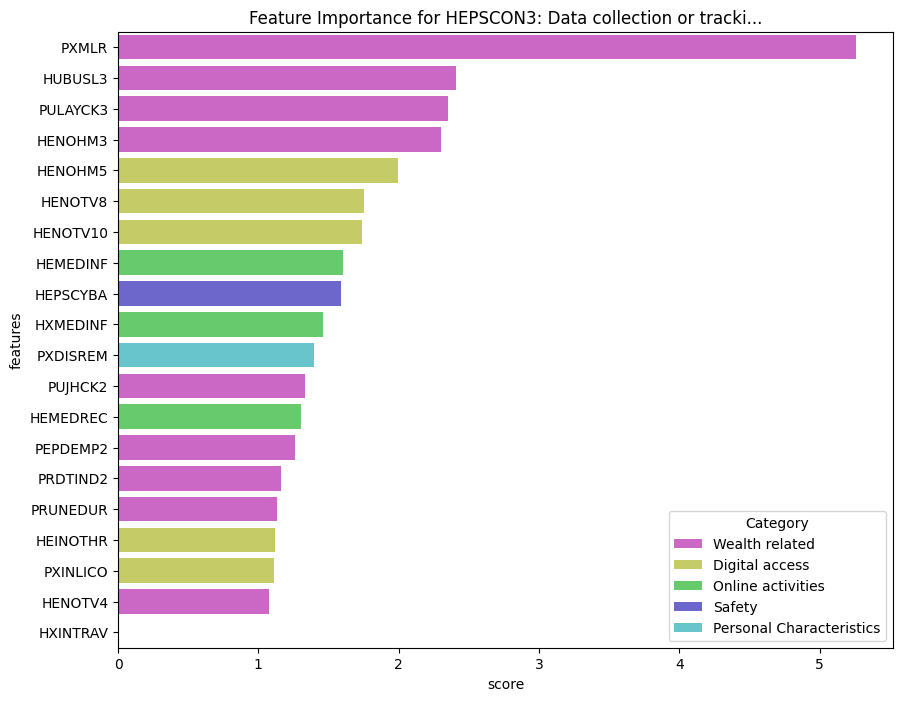

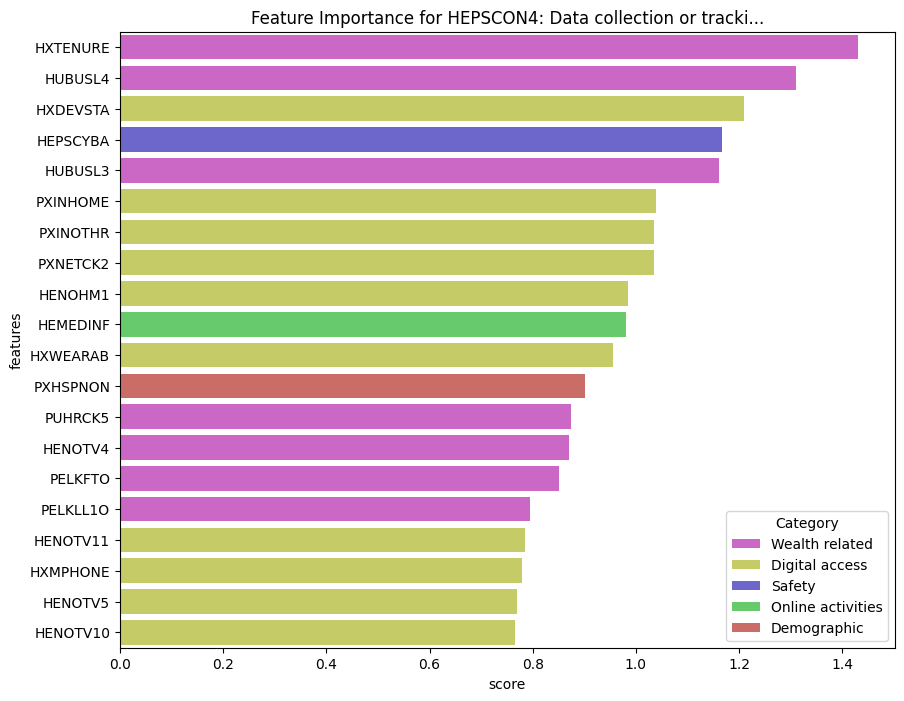

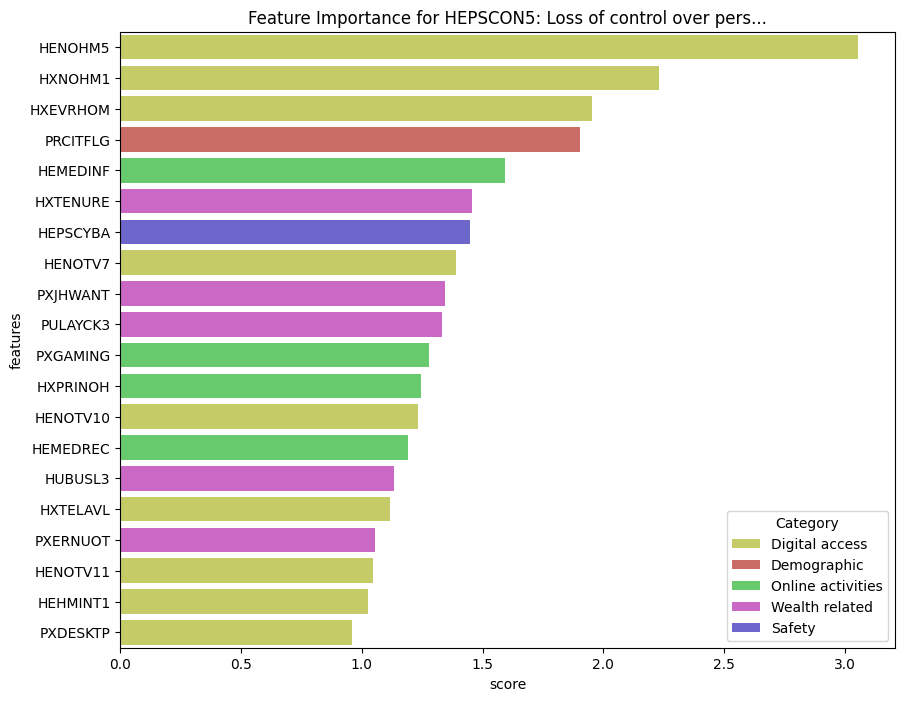

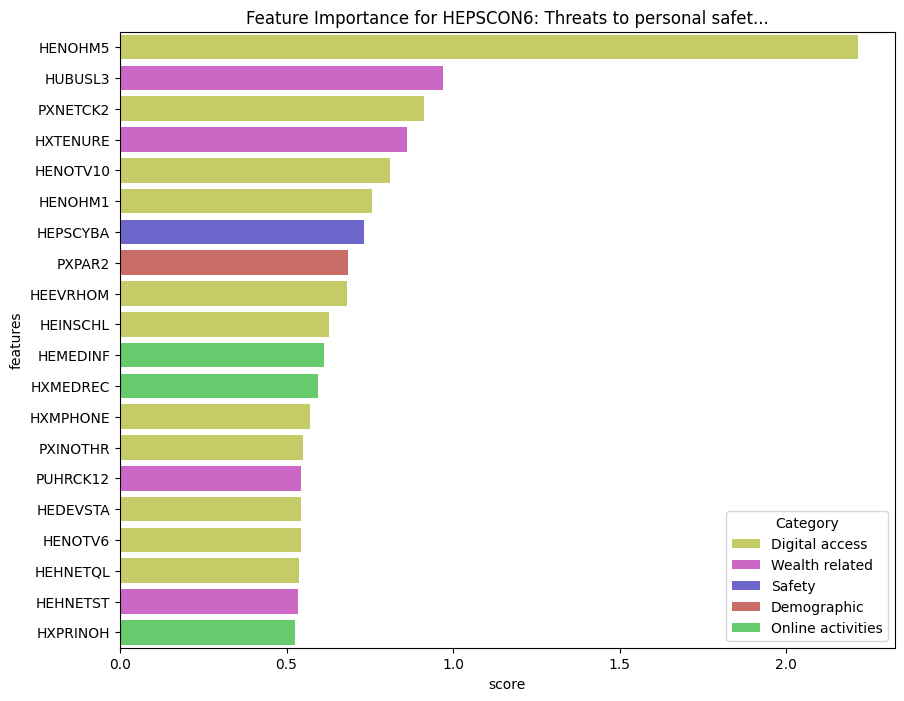

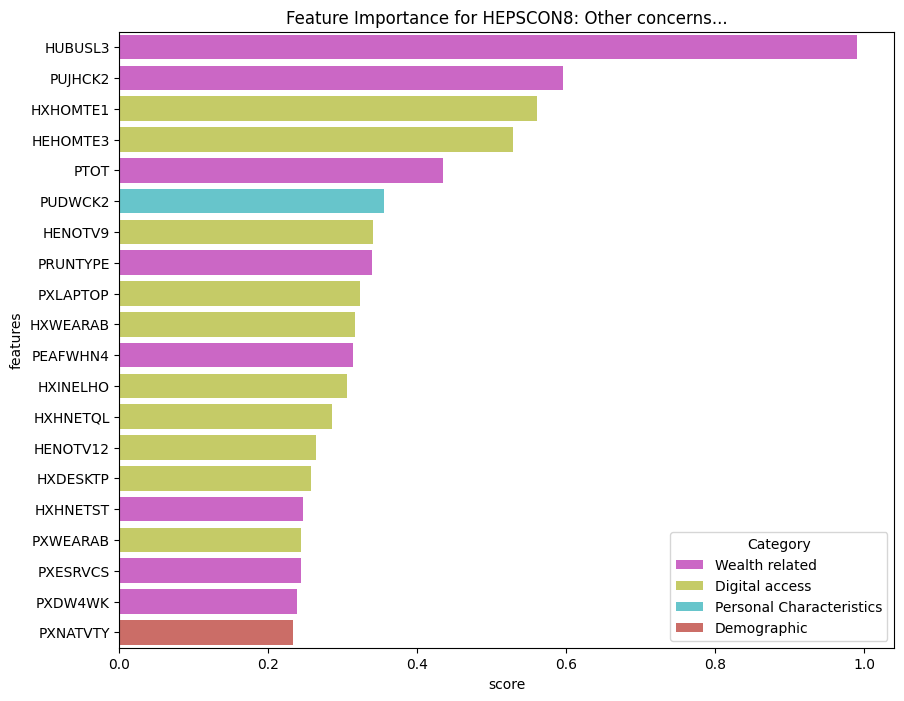

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

path = os.path.join(os.getcwd(), '../res', year)

# Create a color palette
# Create a list of unique categories
all_categories = []
for var_name in feat_dict.keys():
    all_categories += list(feat_dict[var_name].values())
unique_categories = list(set(all_categories))

unique_categories.sort()

# Create a color palette
palette = sns.color_palette("hls", len(unique_categories))

# Create a dictionary mapping each category to a color
color_dict = dict(zip(unique_categories, palette))

for var_name in [f'HEPSPRE{i}' for i in [1,2,3,4,5]] + [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8,]]:
    
    importance_df = pd.read_csv(os.path.join(path, f'{var_name}.csv'))
    # select top 20 rows of the dataframe
    importance_df = importance_df.iloc[:20]

    # plot a bar chart of the feature importance, use the variable names as the y-axis labels, and use 
    # different colors for the bars depending on the category of the variable
    
    var_categories = feat_dict[var_name]

    #rename the first column to 'features'
    importance_df.rename(columns={'Unnamed: 0': 'features'}, inplace=True)

    # Create a new column in importance_df for the categories using var_categories
    importance_df['category'] = importance_df['features'].map(var_categories)

    # Plot the bar chart
    plt.figure(figsize=(10, 8))
    sns.barplot(x='score', y='features', hue='category', data=importance_df, palette=color_dict, dodge=False)

    # Show the legend
    plt.legend(title='Category')

    feature_description_map = ACTIVITIES_MAP if var_name.startswith("HEPSPRE") else CONCERNS_MAP

    plt.title(f'Feature Importance for {var_name}: {feature_description_map[var_name][:25]}...')

    # Show the plot
    plt.show()

    #plt.savefig(path + f'/HEPSPRE{target}_colored.png', dpi=300, bbox_inches='tight')

In [8]:
cats = set()
for var in feat_dict:
    cats.update(feat_dict[var].values())
cats

{'Demographic',
 'Digital access',
 'Disability',
 'Financial',
 'House',
 'Safety',
 'Work'}